In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, LSTM, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


In [2]:
DATA_PATH = 'weather.csv'
SEQUENCE_LENGTH = 7
TRAIN_RATIO = 0.8
EPOCHS = 10
BATCH_SIZE = 64
THRESHOLD = 0.5

FEATURE_COLUMNS = ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'TEMP_RANGE', 'WIND_TEMP_RATIO', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED', 'DAY_OF_YEAR', 'Winter', 'Spring', 'Summer', 'Fall', 'YEAR', 'MONTH' ]
TARGET_COLUMN = 'FIRE_START_DAY'

In [3]:
print("Loading and preprocessing data...")

# Load data
df = pd.read_csv(DATA_PATH)
df['DATE'] = pd.to_datetime(df['DATE'])

# Sort by date to ensure chronological order
df = df.sort_values('DATE').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
print(f"Fire events: {df['FIRE_START_DAY'].sum()} out of {len(df)} days ({df['FIRE_START_DAY'].mean():.2%})")

# Check for missing values after loading
print("\nChecking for missing values:")
print(df.isnull().sum())

# Fill missing values in specified columns with the mean
for col in FEATURE_COLUMNS:
    if df[col].isnull().any():
        mean_val = df[col].mean()
        df[col] = df[col].fillna(mean_val)
        print(f"Filled missing values in '{col}' with mean: {mean_val:.2f}")

# Verify missing values are handled
print("\nChecking for missing values after filling:")
print(df.isnull().sum())

df.head()

Loading and preprocessing data...
Dataset shape: (14970, 17)
Date range: 1984-01-01 00:00:00 to 2024-12-25 00:00:00
Fire events: 4971 out of 14970 days (33.21%)

Checking for missing values:
DATE                     0
PRECIPITATION            0
MAX_TEMP                 0
MIN_TEMP                 0
AVG_WIND_SPEED           3
TEMP_RANGE               0
WIND_TEMP_RATIO          3
LAGGED_PRECIPITATION     0
LAGGED_AVG_WIND_SPEED    0
DAY_OF_YEAR              0
Winter                   0
Spring                   0
Summer                   0
Fall                     0
YEAR                     0
MONTH                    0
FIRE_START_DAY           0
dtype: int64
Filled missing values in 'AVG_WIND_SPEED' with mean: 7.44
Filled missing values in 'WIND_TEMP_RATIO' with mean: 0.11

Checking for missing values after filling:
DATE                     0
PRECIPITATION            0
MAX_TEMP                 0
MIN_TEMP                 0
AVG_WIND_SPEED           0
TEMP_RANGE               0
WIND_TEMP_RATI

,DATE,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,TEMP_RANGE,WIND_TEMP_RATIO,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR,Winter,Spring,Summer,Fall,YEAR,MONTH,FIRE_START_DAY
0,1984-01-01,0.0,79,51,4.70,28,0.059494,0.0,4.700,1,1,0,0,0,1984,1,0
1,1984-01-02,0.0,71,46,5.59,25,0.078732,0.0,5.145,2,1,0,0,0,1984,1,0
2,1984-01-03,0.0,70,47,5.37,23,0.076714,0.0,5.220,3,1,0,0,0,1984,1,0
3,1984-01-04,0.0,76,45,4.70,31,0.061842,0.0,5.090,4,1,0,0,0,1984,1,0
4,1984-01-05,0.0,74,49,5.14,25,0.069459,0.0,5.100,5,1,0,0,0,1984,1,0


In [16]:
import numpy as np

print("Detailed Data Analysis using NumPy")
print("="*50)

# Convert relevant columns to numpy arrays for analysis
numerical_cols = ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'FIRE_START_DAY']
data_arrays = {col: df[col].to_numpy(dtype=np.float64) for col in numerical_cols}

print("\n1. BASIC STATISTICS:")
for col, arr in data_arrays.items():
    print(f"\n{col}:")
    print(f"  Mean: {np.mean(arr):.4f}")
    print(f"  Standard Deviation: {np.std(arr):.4f}")
    print(f"  Minimum: {np.min(arr):.4f}")
    print(f"  Maximum: {np.max(arr):.4f}")
    print(f"  Median: {np.median(arr):.4f}")
    print(f"  25th Percentile: {np.percentile(arr, 25):.4f}")
    print(f"  75th Percentile: {np.percentile(arr, 75):.4f}")

print("\n2. CORRELATION ANALYSIS:")
# Compute correlation matrix for numerical features
corr_matrix = np.corrcoef([data_arrays[col] for col in numerical_cols])
print("Correlation Matrix:")
print("Features:", numerical_cols)
for i, col1 in enumerate(numerical_cols):
    for j, col2 in enumerate(numerical_cols):
        if i <= j:  # Upper triangle
            print(f"  {col1} vs {col2}: {corr_matrix[i,j]:.4f}")

print("\n3. FIRE EVENT ANALYSIS:")
fire_data = data_arrays['FIRE_START_DAY']
fire_indices = np.where(fire_data == 1)[0]
print(f"  Total fire events: {len(fire_indices)}")
print(f"  Fire rate: {len(fire_indices)/len(fire_data):.4f}")
print(f"  Average fires per 100 days: {len(fire_indices)/len(fire_data)*100:.2f}")

# Analyze conditions during fire events
print("\n4. CONDITIONS DURING FIRE EVENTS:")
fire_precip = df.loc[fire_indices, 'PRECIPITATION'].to_numpy(dtype=np.float64)
fire_max_temp = df.loc[fire_indices, 'MAX_TEMP'].to_numpy(dtype=np.float64)
fire_min_temp = df.loc[fire_indices, 'MIN_TEMP'].to_numpy(dtype=np.float64)
fire_wind = df.loc[fire_indices, 'AVG_WIND_SPEED'].to_numpy(dtype=np.float64)

print(f"  Average precipitation during fires: {np.mean(fire_precip):.4f}")
print(f"  Average max temp during fires: {np.mean(fire_max_temp):.2f}°F")
print(f"  Average min temp during fires: {np.mean(fire_min_temp):.2f}°F")
print(f"  Average wind speed during fires: {np.mean(fire_wind):.2f}")

print("\n5. TEMPORAL PATTERNS:")
# Monthly patterns using numpy
months = df['DATE'].dt.month.to_numpy(dtype=np.int32)
monthly_fire_rate = []
for month in range(1, 13):
    month_mask = months == month
    fire_rate_month = np.mean(fire_data[month_mask])
    monthly_fire_rate.append(fire_rate_month)
    print(f"  Month {month}: Fire rate = {fire_rate_month:.4f}")

print("\n6. OUTLIER DETECTION:")
for col, arr in data_arrays.items():
    if col != 'FIRE_START_DAY':
        q1 = np.percentile(arr, 25)
        q3 = np.percentile(arr, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = np.sum((arr < lower_bound) | (arr > upper_bound))
        print(f"  {col}: {outliers} outliers detected")

print("\nNumPy analysis complete!")


Detailed Data Analysis using NumPy

1. BASIC STATISTICS:

PRECIPITATION:
  Mean: 0.0324
  Standard Deviation: 0.1796
  Minimum: 0.0000
  Maximum: 4.5300
  Median: 0.0000
  25th Percentile: 0.0000
  75th Percentile: 0.0000

MAX_TEMP:
  Mean: 70.5401
  Standard Deviation: 7.2634
  Minimum: 50.0000
  Maximum: 106.0000
  Median: 70.0000
  25th Percentile: 65.0000
  75th Percentile: 75.0000

MIN_TEMP:
  Mean: 56.5037
  Standard Deviation: 6.7647
  Minimum: 33.0000
  Maximum: 77.0000
  Median: 57.0000
  25th Percentile: 51.0000
  75th Percentile: 62.0000

AVG_WIND_SPEED:
  Mean: 7.4361
  Standard Deviation: 2.1284
  Minimum: 1.7900
  Maximum: 26.1700
  Median: 7.1600
  25th Percentile: 6.0400
  75th Percentile: 8.5000

FIRE_START_DAY:
  Mean: 0.3321
  Standard Deviation: 0.4710
  Minimum: 0.0000
  Maximum: 1.0000
  Median: 0.0000
  25th Percentile: 0.0000
  75th Percentile: 1.0000

2. CORRELATION ANALYSIS:
Correlation Matrix:
Features: ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEE

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

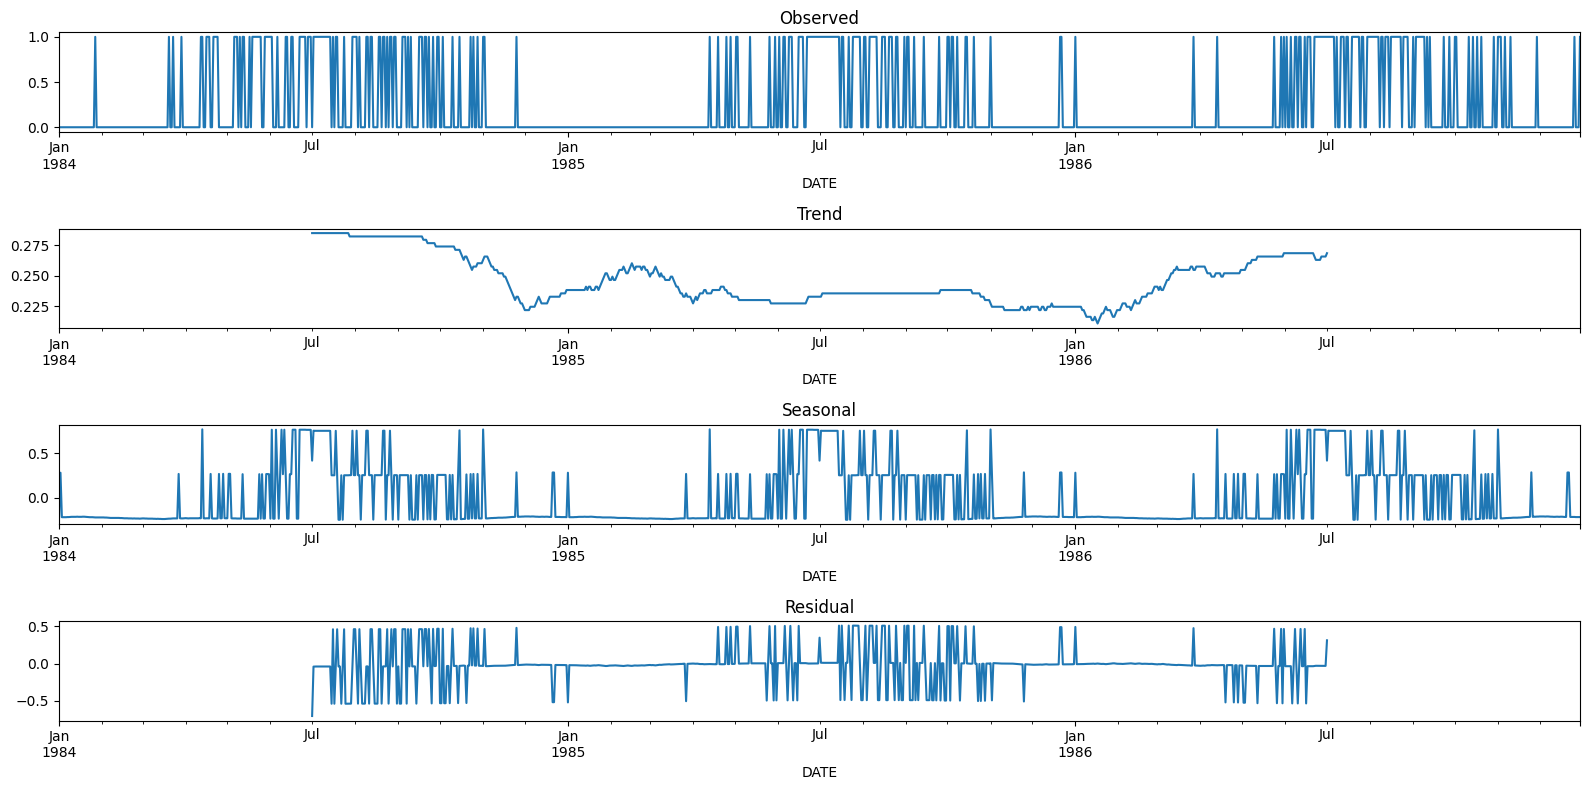

In [5]:
# Take only the first 3650 days for seasonal decomposition
df_3650 = df.head(1095)

# Set the date column as index for the first 3650 days
df_time_indexed_3650 = df_3650.set_index('DATE')

# Use a 365-day period to look for annual seasonal patterns
results = seasonal_decompose(df_time_indexed_3650['FIRE_START_DAY'], period=365)

# Create your own subplots with ultra wide size
fig, axes = plt.subplots(4, 1, figsize=(16, 8))
results.observed.plot(ax=axes[0], title='Observed')
results.trend.plot(ax=axes[1], title='Trend')
results.seasonal.plot(ax=axes[2], title='Seasonal')
results.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

DETAILED DATA ANALYSIS - FIRST 3 YEARS

1. DATASET OVERVIEW:
   Total records: 1,095
   Date range: 1984-01-01 00:00:00 to 1986-12-30 00:00:00
   Duration: 1094 days
   Years covered: 3

2. FIRE EVENTS ANALYSIS:
   Total fire events: 287
   Fire rate: 26.21%
   Average fires per year: 95.7

3. FEATURE STATISTICS:
       PRECIPITATION     MAX_TEMP     MIN_TEMP  AVG_WIND_SPEED   TEMP_RANGE  \
count    1095.000000  1095.000000  1095.000000     1095.000000  1095.000000   
mean        0.030192    70.810046    56.290411        7.872749    14.519635   
std         0.176623     7.309712     6.829850        1.984312     5.946388   
min         0.000000    54.000000    39.000000        3.360000     3.000000   
25%         0.000000    66.000000    52.000000        6.710000    10.000000   
50%         0.000000    71.000000    56.000000        7.610000    13.000000   
75%         0.000000    75.000000    61.000000        8.500000    17.000000   
max         2.660000    97.000000    77.000000       

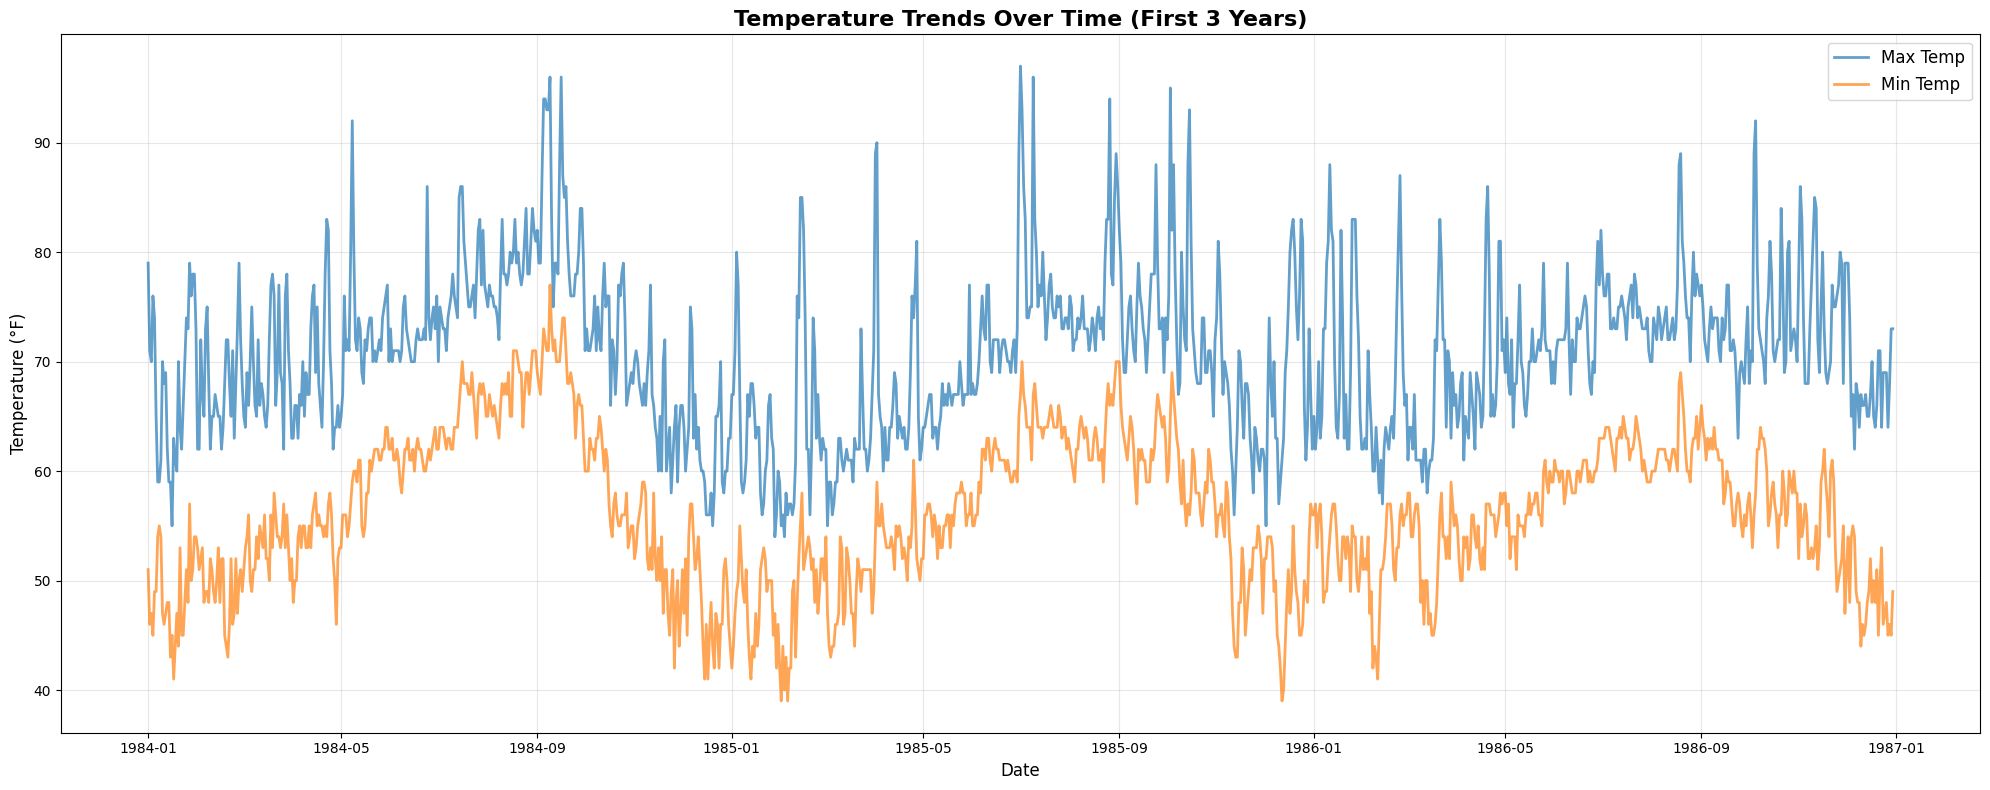

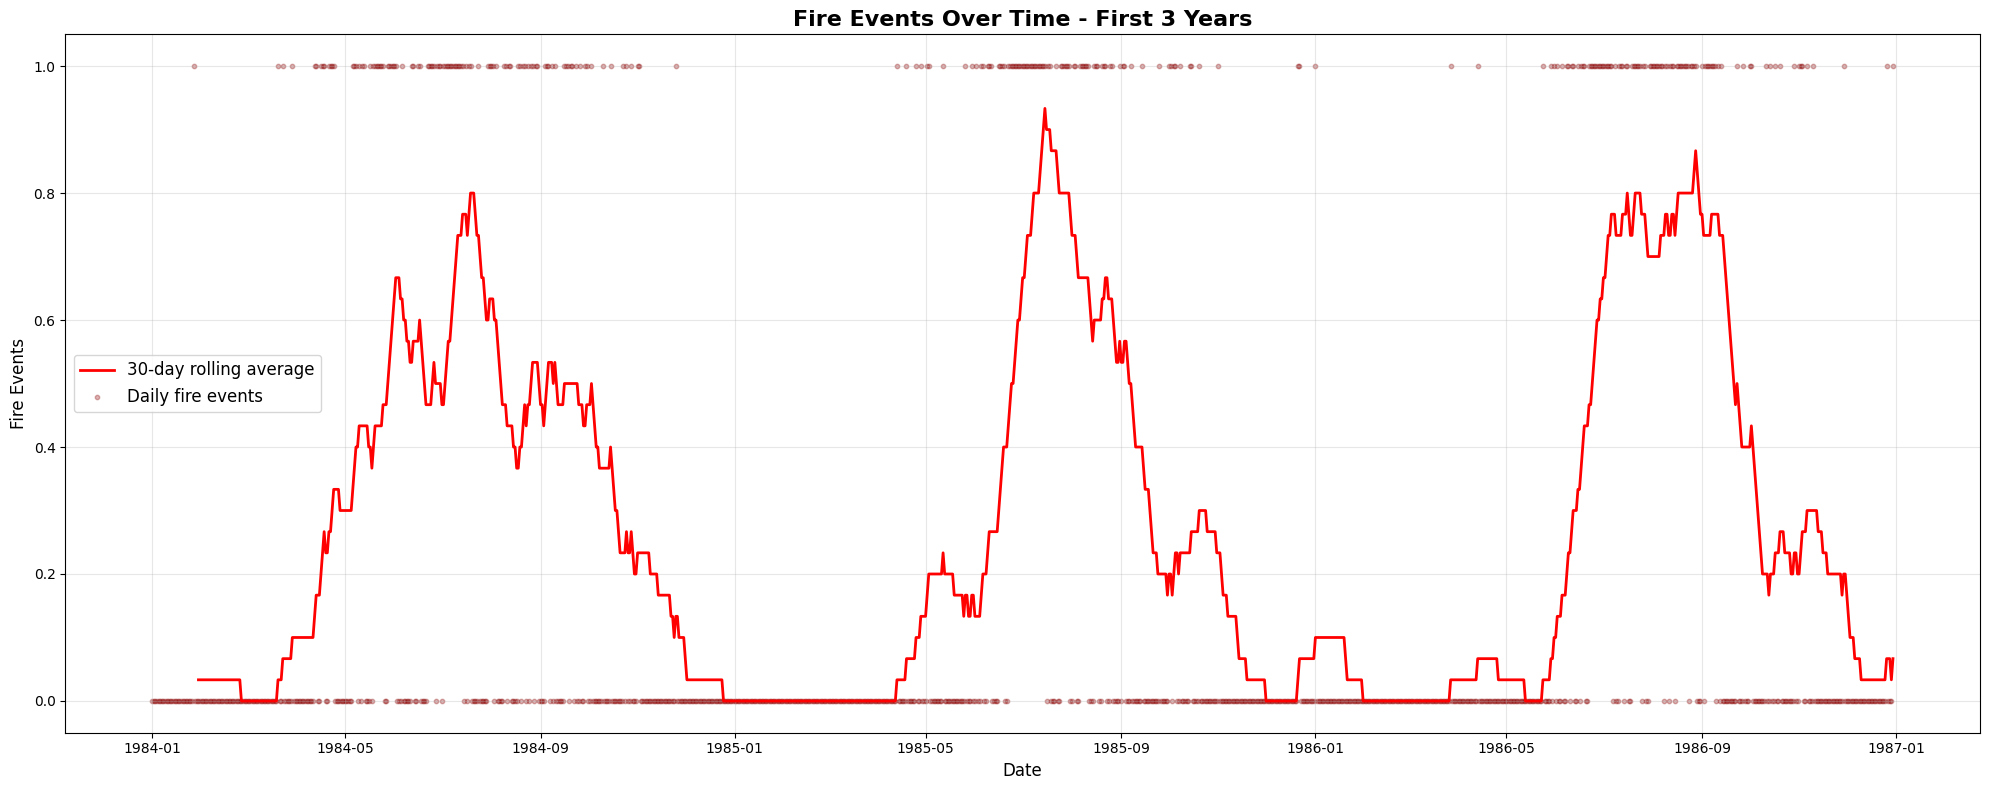

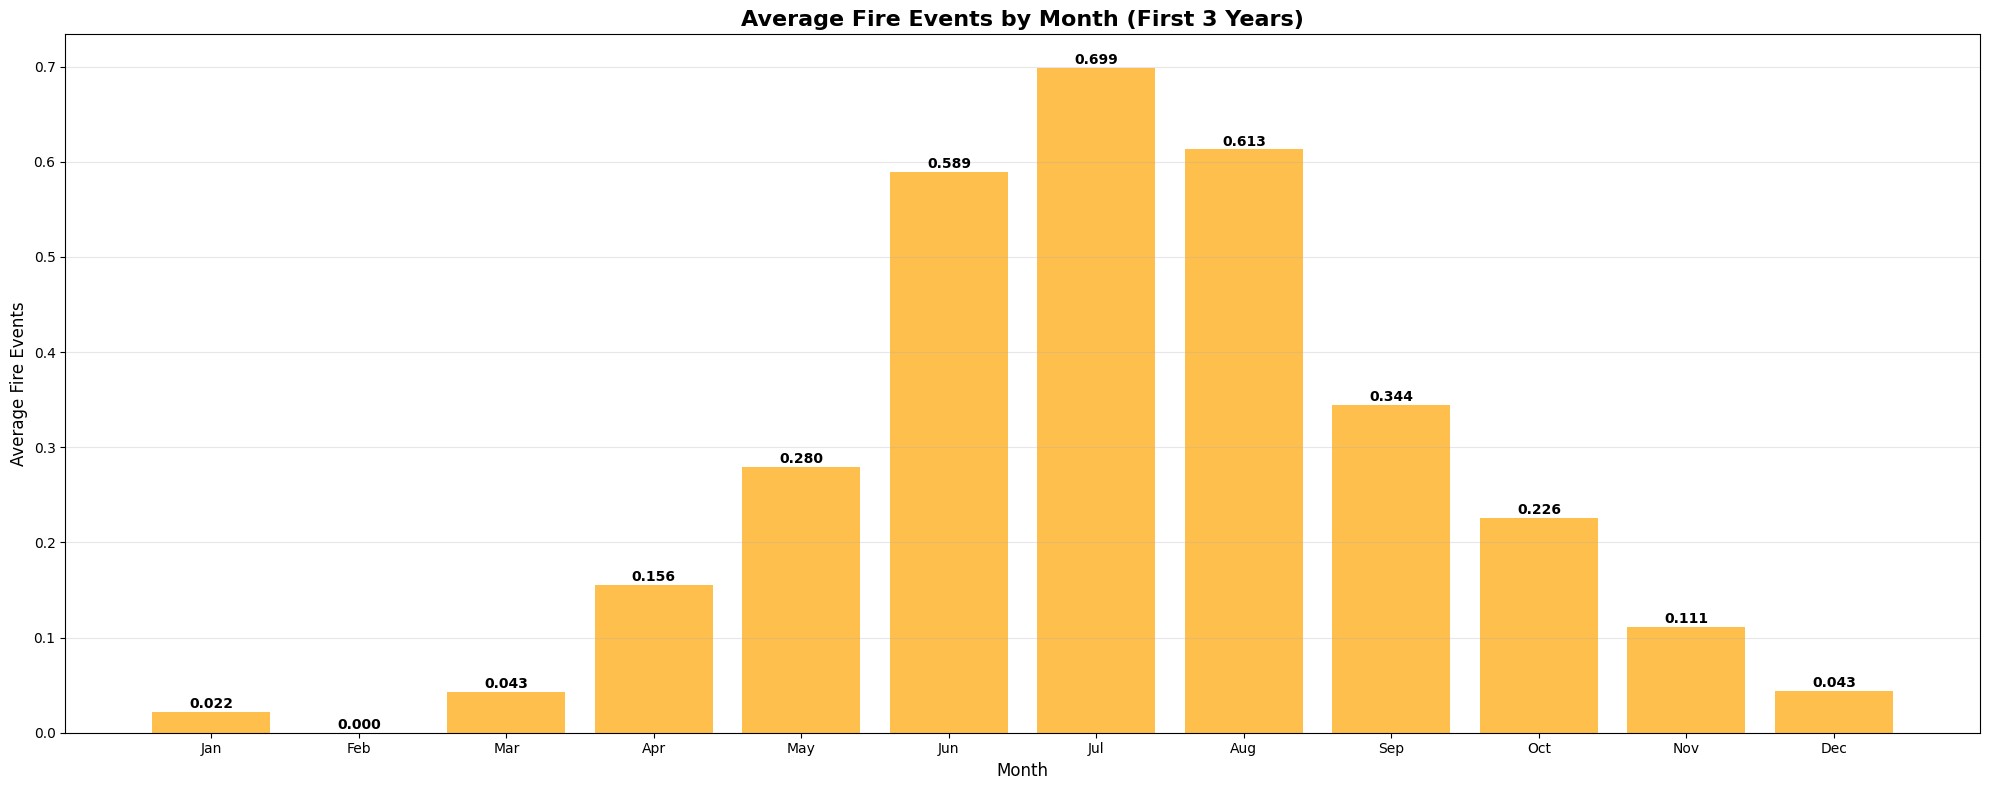

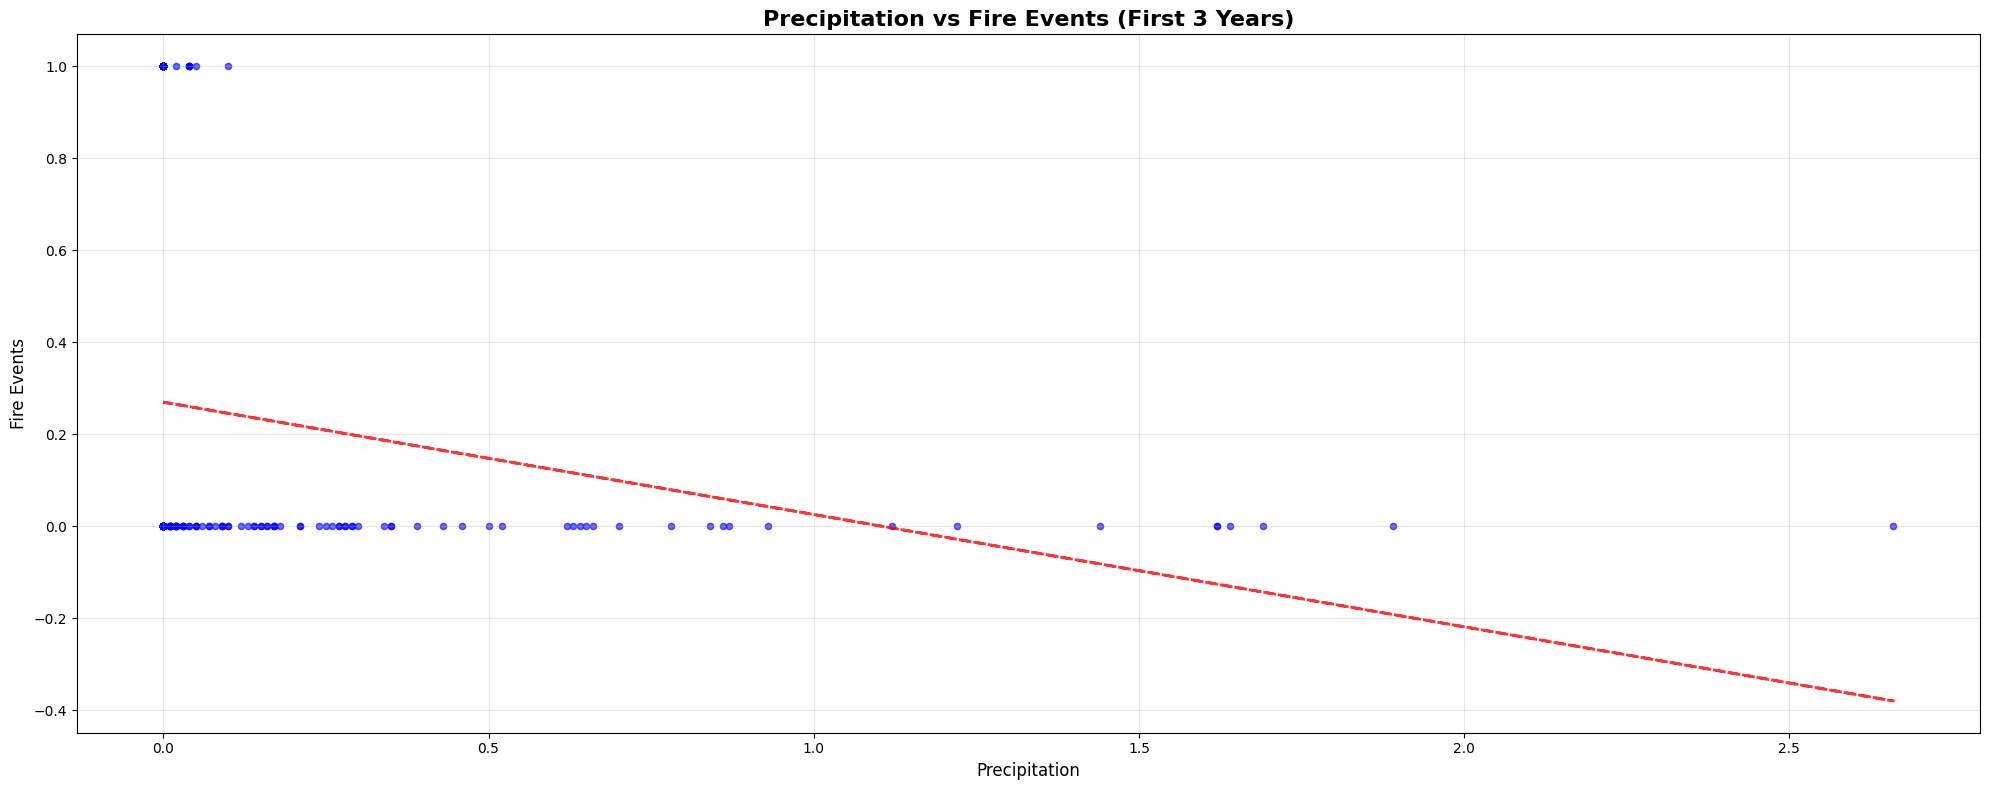

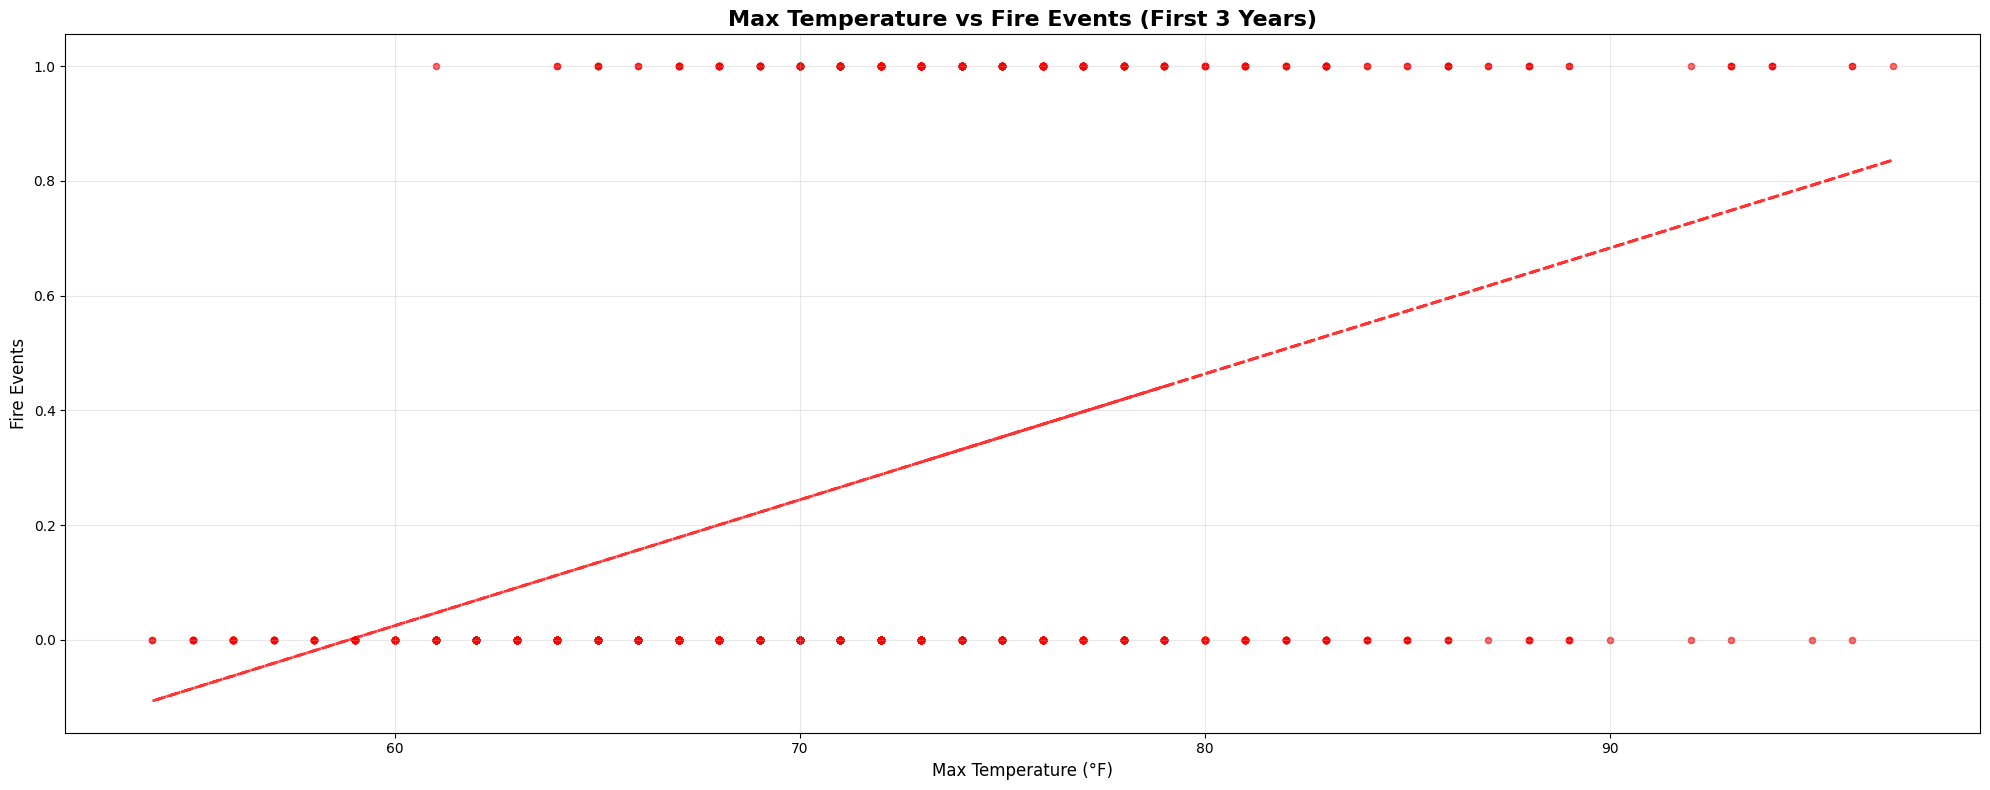

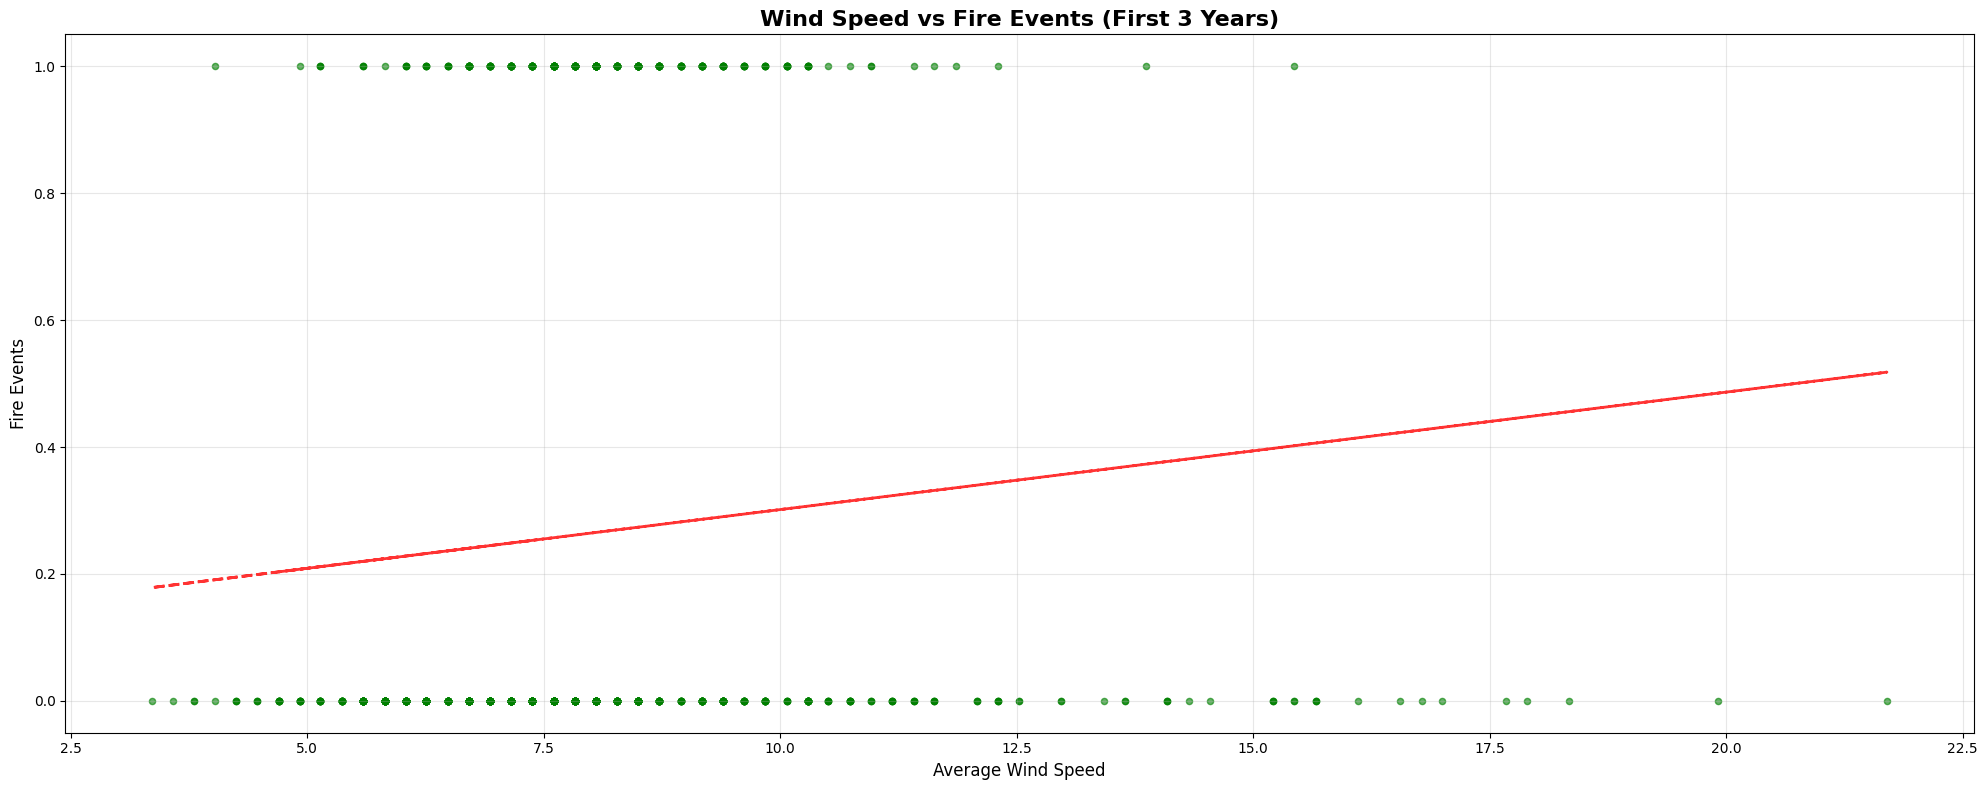


SUMMARY INSIGHTS - FIRST 3 YEARS

8. KEY FINDINGS:
   • Dataset covers 3 years
   • 26.9% of days had fire events
   • Strongest correlation with fire events: Summer (0.491)
   • Weakest correlation with fire events: Winter (-0.312)
   • Peak fire month: July
   • Average temperature range: 14.5°F
   • Maximum temperature range: 38.0°F
   • Year with most fires: 1984 (104 fires)

Analysis complete for first 3 years!


In [6]:
# Set date as index for analysis
df_time_indexed = df.set_index('DATE')

# Take only first 3 years (approximately 1095 days)
df_3years = df_time_indexed.head(1095)

# 1. BASIC STATISTICS
print("="*60)
print("DETAILED DATA ANALYSIS - FIRST 3 YEARS")
print("="*60)

print("\n1. DATASET OVERVIEW:")
print(f"   Total records: {len(df_3years):,}")
print(f"   Date range: {df_3years.index.min()} to {df_3years.index.max()}")
print(f"   Duration: {(df_3years.index.max() - df_3years.index.min()).days} days")
print(f"   Years covered: {df_3years.index.max().year - df_3years.index.min().year + 1}")

print("\n2. FIRE EVENTS ANALYSIS:")
fire_events = df_3years['FIRE_START_DAY'].sum()
fire_rate = (fire_events / len(df_3years)) * 100
print(f"   Total fire events: {fire_events:,}")
print(f"   Fire rate: {fire_rate:.2f}%")
print(f"   Average fires per year: {fire_events / 3:.1f}")

print("\n3. FEATURE STATISTICS:")
print(df_3years.describe())

# 2. TEMPORAL ANALYSIS
print("\n" + "="*60)
print("TEMPORAL PATTERNS ANALYSIS - FIRST 3 YEARS")
print("="*60)

# Monthly fire patterns
monthly_fires = df_3years.groupby(pd.to_datetime(df_3years.index).month)['FIRE_START_DAY'].agg(['mean', 'sum', 'count'])
print("\n4. MONTHLY FIRE PATTERNS:")
for month in range(1, 13):
    month_name = pd.Timestamp(2020, month, 1).strftime('%B')
    mean_fires = monthly_fires.loc[month, 'mean']
    total_fires = monthly_fires.loc[month, 'sum']
    print(f"   {month_name:9}: {mean_fires:.4f} avg, {total_fires:4.0f} total")

# Seasonal analysis
seasonal_fires = df_3years.groupby(['Winter', 'Spring', 'Summer', 'Fall'])['FIRE_START_DAY'].agg(['mean', 'sum'])
print("\n5. SEASONAL FIRE PATTERNS:")
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for i, season in enumerate(seasons):
    if i < len(seasonal_fires):
        mean_fires = seasonal_fires.iloc[i]['mean']
        total_fires = seasonal_fires.iloc[i]['sum']
        print(f"   {season:6}: {mean_fires:.4f} avg, {total_fires:4.0f} total")

# 3. CORRELATION ANALYSIS
print("\n" + "="*60)
print("CORRELATION ANALYSIS - FIRST 3 YEARS")
print("="*60)

# Correlation with fire events
correlations = df_3years.corr()['FIRE_START_DAY'].sort_values(ascending=False)
print("\n6. FEATURE CORRELATIONS WITH FIRE EVENTS:")
for feature, corr in correlations.items():
    if feature != 'FIRE_START_DAY':
        print(f"   {feature:20}: {corr:6.3f}")

# 4. YEARLY BREAKDOWN
print("\n" + "="*60)
print("YEARLY BREAKDOWN - FIRST 3 YEARS")
print("="*60)

# Yearly trends
yearly_stats = df_3years.groupby(pd.to_datetime(df_3years.index).year).agg({
    'FIRE_START_DAY': ['sum', 'mean'],
    'MAX_TEMP': 'mean',
    'MIN_TEMP': 'mean',
    'PRECIPITATION': 'sum',
    'AVG_WIND_SPEED': 'mean'
})

print("\n7. YEARLY STATISTICS:")
print("   Year | Fires | Fire Rate | Avg Max Temp | Avg Min Temp | Total Precip | Avg Wind")
print("   " + "-"*70)
for year in yearly_stats.index:
    fires = yearly_stats.loc[year, ('FIRE_START_DAY', 'sum')]
    fire_rate = pd.to_numeric(yearly_stats.loc[year, ('FIRE_START_DAY', 'mean')]) * 100
    max_temp = yearly_stats.loc[year, ('MAX_TEMP', 'mean')]
    min_temp = yearly_stats.loc[year, ('MIN_TEMP', 'mean')]
    precip = yearly_stats.loc[year, ('PRECIPITATION', 'sum')]
    wind = yearly_stats.loc[year, ('AVG_WIND_SPEED', 'mean')]
    print(f"   {year:4} | {fires:5.0f} | {fire_rate:8.2f}% | {max_temp:11.1f}°F | {min_temp:11.1f}°F | {precip:12.1f} | {wind:8.1f}")

# 5. SEPARATE VISUALIZATIONS
print("\n" + "="*60)
print("GENERATING 6 SEPARATE VISUALIZATIONS - FIRST 3 YEARS")
print("="*60)

# 1. Temperature Trends Over Time
plt.figure(figsize=(20, 8))
plt.plot(df_3years.index, df_3years['MAX_TEMP'], label='Max Temp', alpha=0.7, linewidth=2)
plt.plot(df_3years.index, df_3years['MIN_TEMP'], label='Min Temp', alpha=0.7, linewidth=2)
plt.title('Temperature Trends Over Time (First 3 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°F)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Fire Events Over Time
plt.figure(figsize=(20, 8))
plt.plot(df_3years.index, df_3years['FIRE_START_DAY'].rolling(30).mean(), label='30-day rolling average', color='red', linewidth=2)
plt.scatter(df_3years.index, df_3years['FIRE_START_DAY'], alpha=0.3, s=10, color='darkred', label='Daily fire events')
plt.title('Fire Events Over Time - First 3 Years', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Fire Events', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Monthly Fire Patterns
plt.figure(figsize=(20, 8))
monthly_avg = df_3years.groupby(pd.to_datetime(df_3years.index).month)['FIRE_START_DAY'].mean()
bars = plt.bar(range(1,13), np.asarray(monthly_avg.values), color='orange', alpha=0.7)
plt.title('Average Fire Events by Month (First 3 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Fire Events', fontsize=12)
plt.xticks(range(1,13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Precipitation vs Fire Events
plt.figure(figsize=(20, 8))
plt.scatter(df_3years['PRECIPITATION'], df_3years['FIRE_START_DAY'], alpha=0.6, s=20, color='blue')
plt.title('Precipitation vs Fire Events (First 3 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Precipitation', fontsize=12)
plt.ylabel('Fire Events', fontsize=12)
plt.grid(True, alpha=0.3)
# Add trend line
z = np.polyfit(df_3years['PRECIPITATION'], df_3years['FIRE_START_DAY'], 1)
p = np.poly1d(z)
plt.plot(df_3years['PRECIPITATION'], p(df_3years['PRECIPITATION']), "r--", alpha=0.8, linewidth=2)
plt.tight_layout()
plt.show()

# 5. Temperature vs Fire Events
plt.figure(figsize=(20, 8))
plt.scatter(df_3years['MAX_TEMP'], df_3years['FIRE_START_DAY'], alpha=0.6, s=20, color='red')
plt.title('Max Temperature vs Fire Events (First 3 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Max Temperature (°F)', fontsize=12)
plt.ylabel('Fire Events', fontsize=12)
plt.grid(True, alpha=0.3)
# Add trend line
z = np.polyfit(df_3years['MAX_TEMP'], df_3years['FIRE_START_DAY'], 1)
p = np.poly1d(z)
plt.plot(df_3years['MAX_TEMP'], p(df_3years['MAX_TEMP']), "r--", alpha=0.8, linewidth=2)
plt.tight_layout()
plt.show()

# 6. Wind Speed vs Fire Events
plt.figure(figsize=(20, 8))
plt.scatter(df_3years['AVG_WIND_SPEED'], df_3years['FIRE_START_DAY'], alpha=0.6, s=20, color='green')
plt.title('Wind Speed vs Fire Events (First 3 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Average Wind Speed', fontsize=12)
plt.ylabel('Fire Events', fontsize=12)
plt.grid(True, alpha=0.3)
# Add trend line
z = np.polyfit(df_3years['AVG_WIND_SPEED'], df_3years['FIRE_START_DAY'], 1)
p = np.poly1d(z)
plt.plot(df_3years['AVG_WIND_SPEED'], p(df_3years['AVG_WIND_SPEED']), "r--", alpha=0.8, linewidth=2)
plt.tight_layout()
plt.show()

# 6. SUMMARY STATISTICS
print("\n" + "="*60)
print("SUMMARY INSIGHTS - FIRST 3 YEARS")
print("="*60)

print(f"\n8. KEY FINDINGS:")
print(f"   • Dataset covers {df_3years.index.max().year - df_3years.index.min().year + 1} years")
print(f"   • {fire_rate:.1f}% of days had fire events")
print(f"   • Strongest correlation with fire events: {correlations.index[1]} ({correlations.iloc[1]:.3f})")
print(f"   • Weakest correlation with fire events: {correlations.index[-1]} ({correlations.iloc[-1]:.3f})")

# Find peak fire month
peak_month = int(monthly_fires['mean'].idxmax())
peak_month_name = pd.Timestamp(2020, peak_month, 1).strftime('%B')
print(f"   • Peak fire month: {peak_month_name}")

# Temperature range analysis
temp_range = df_3years['MAX_TEMP'] - df_3years['MIN_TEMP']
print(f"   • Average temperature range: {temp_range.mean():.1f}°F")
print(f"   • Maximum temperature range: {temp_range.max():.1f}°F")

# Year with most fires
year_most_fires = yearly_stats[('FIRE_START_DAY', 'sum')].idxmax()
fires_in_peak_year = yearly_stats.loc[year_most_fires, ('FIRE_START_DAY', 'sum')]
print(f"   • Year with most fires: {year_most_fires} ({fires_in_peak_year:.0f} fires)")

print("\nAnalysis complete for first 3 years!")

In [7]:
# Previous day effects
df_3years['PREV_DAY_FIRE'] = df_3years['FIRE_START_DAY'].shift(1)
df_3years['PREV_DAY_TEMP'] = df_3years['MAX_TEMP'].shift(1)
df_3years['PREV_DAY_PRECIP'] = df_3years['PRECIPITATION'].shift(1)

# Fire clustering analysis
fire_days = df_3years[df_3years['FIRE_START_DAY'] == 1]
consecutive_fires = 0
max_consecutive = 0
for i in range(1, len(df_3years)):
    if df_3years['FIRE_START_DAY'].iloc[i] == 1 and df_3years['FIRE_START_DAY'].iloc[i-1] == 1:
        consecutive_fires += 1
        max_consecutive = max(max_consecutive, consecutive_fires)
    else:
        consecutive_fires = 0

print(f"Maximum consecutive fire days: {max_consecutive}")

Maximum consecutive fire days: 23


C:\Users\nakul\AppData\Local\Temp\ipykernel_45488\867543843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3years['PREV_DAY_FIRE'] = df_3years['FIRE_START_DAY'].shift(1)
C:\Users\nakul\AppData\Local\Temp\ipykernel_45488\867543843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3years['PREV_DAY_TEMP'] = df_3years['MAX_TEMP'].shift(1)
C:\Users\nakul\AppData\Local\Temp\ipykernel_45488\867543843.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [8]:
print(f"\nSplitting data: {TRAIN_RATIO:.0%} training, {1-TRAIN_RATIO:.0%} testing")

# Calculate split point
split_idx = int(len(df) * TRAIN_RATIO)

# Split data
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"Training set: {len(train_df)} samples")
print(f"Testing set: {len(test_df)} samples")


Splitting data: 80% training, 20% testing
Training set: 11976 samples
Testing set: 2994 samples


In [9]:
def create_sequences(df, features, target, sequence_length):
    """Create sequences for LSTM model"""
    X, y = [], []
    for i in range(sequence_length, len(df)):
        # Get sequence of features
        sequence = features[i-sequence_length:i]
        X.append(sequence)
        y.append(target.iloc[i])
    return np.array(X), np.array(y)

print("\nPreparing data for training...")

# Initialize scaler
scaler = StandardScaler()

# Scale features
train_features = train_df[FEATURE_COLUMNS].values
test_features = test_df[FEATURE_COLUMNS].values

# Fit scaler on training data only and transform both
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Create sequences
X_train, y_train = create_sequences(
    train_df, 
    train_features_scaled, 
    train_df[TARGET_COLUMN],
    SEQUENCE_LENGTH
)

X_test, y_test = create_sequences(
    test_df, 
    test_features_scaled, 
    test_df[TARGET_COLUMN],
    SEQUENCE_LENGTH
)

print(f"Training sequences: {X_train.shape}")
print(f"Testing sequences: {X_test.shape}")


Preparing data for training...
Training sequences: (11969, 7, 15)
Testing sequences: (2987, 7, 15)


In [10]:
print("\nBuilding and training LSTM model...")

# Build Model
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(16, return_sequences=False),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

# Calculate aggressive class weights to favor fire prediction
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Increase weight for fire class (class 1)
class_weights_array[1] *= 3.0  # Triple the weight for fire class
class_weight_dict = dict(zip(np.unique(y_train), class_weights_array))
print(f"Class weights (fire class boosted): {class_weight_dict}")

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True,
    min_delta=0
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=30,
    min_lr=0
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

model.save('fire_model.keras')


Building and training LSTM model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 32)             6144      
                                                                 
 dropout (Dropout)           (None, 7, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,425

In [11]:
test_features_scaled = np.array(test_features_scaled)


print(f"\nPerforming iterative forecasting with threshold {THRESHOLD}...")

predictions = []
actual_values = []
prediction_dates = []
prediction_probabilities = []

# Start from the 8th day (index 7) in the test set
for i in range(SEQUENCE_LENGTH, len(test_df)):
    # Get the 7-day window of scaled features
    window_features = test_features_scaled[i-SEQUENCE_LENGTH:i]
    window_features = window_features.reshape(1, SEQUENCE_LENGTH, -1)
    
    # Make prediction
    pred_proba = model.predict(window_features, verbose=0)
    pred = (pred_proba > THRESHOLD).astype(int)[0][0]
    
    # Store results
    predictions.append(pred)
    prediction_probabilities.append(pred_proba[0][0])
    actual_values.append(test_df.iloc[i][TARGET_COLUMN])
    prediction_dates.append(test_df.iloc[i]['DATE'])
    
    print(f"Date: {test_df.iloc[i]['DATE'].strftime('%Y-%m-%d')}, "
          f"Predicted: {pred} (prob: {pred_proba[0][0]:.4f}), "
          f"Actual: {test_df.iloc[i][TARGET_COLUMN]}")

print(f"\nPrediction probabilities range: {min(prediction_probabilities):.4f} to {max(prediction_probabilities):.4f}")
print(f"Mean prediction probability: {np.mean(prediction_probabilities):.4f}")
print(f"Predictions with value 1: {sum(predictions)} out of {len(predictions)}")


Performing iterative forecasting with threshold 0.5...
Date: 2016-10-22, Predicted: 1 (prob: 0.7859), Actual: 0
Date: 2016-10-23, Predicted: 1 (prob: 0.7596), Actual: 0
Date: 2016-10-24, Predicted: 1 (prob: 0.7369), Actual: 1
Date: 2016-10-25, Predicted: 1 (prob: 0.7364), Actual: 0
Date: 2016-10-26, Predicted: 1 (prob: 0.7522), Actual: 0
Date: 2016-10-27, Predicted: 1 (prob: 0.7592), Actual: 0
Date: 2016-10-28, Predicted: 1 (prob: 0.7472), Actual: 0
Date: 2016-10-22, Predicted: 1 (prob: 0.7859), Actual: 0
Date: 2016-10-23, Predicted: 1 (prob: 0.7596), Actual: 0
Date: 2016-10-24, Predicted: 1 (prob: 0.7369), Actual: 1
Date: 2016-10-25, Predicted: 1 (prob: 0.7364), Actual: 0
Date: 2016-10-26, Predicted: 1 (prob: 0.7522), Actual: 0
Date: 2016-10-27, Predicted: 1 (prob: 0.7592), Actual: 0
Date: 2016-10-28, Predicted: 1 (prob: 0.7472), Actual: 0
Date: 2016-10-29, Predicted: 1 (prob: 0.7483), Actual: 1
Date: 2016-10-30, Predicted: 1 (prob: 0.7590), Actual: 0
Date: 2016-10-31, Predicted: 1 (


Creating visualization...


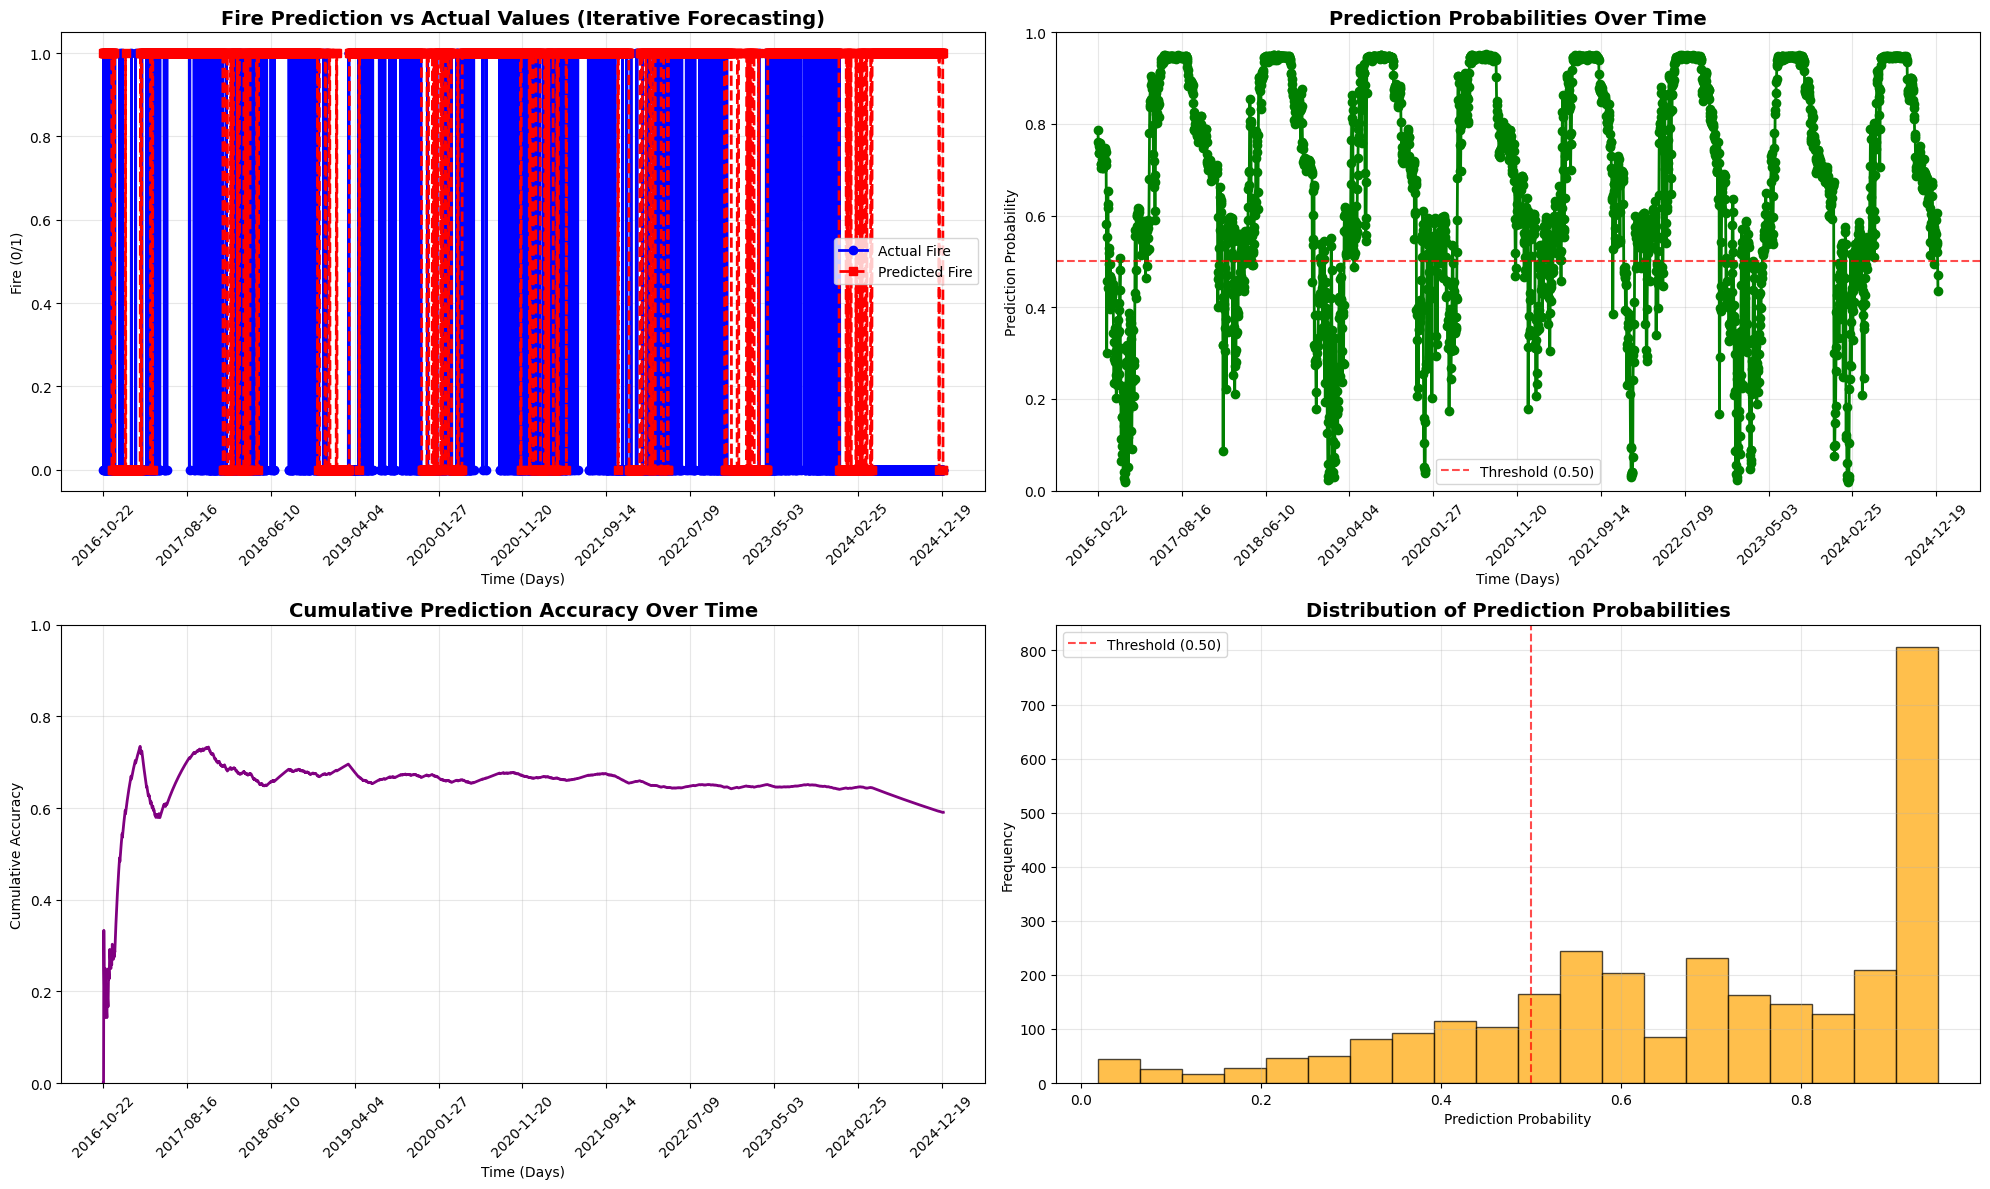


Final Iterative Forecasting Accuracy: 0.5909
Total predictions made: 2987
Correct predictions: 1765
Predicted fire days: 2336
Actual fire days: 1200


In [ ]:
print("\nCreating visualization...")

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Time series of predictions vs actual
dates = [d.strftime('%Y-%m-%d') for d in prediction_dates]
x_indices = range(len(dates))

ax1.plot(x_indices, actual_values, 'b-', label='Actual Fire', linewidth=2, marker='o')
ax1.plot(x_indices, predictions, 'r--', label='Predicted Fire', linewidth=2, marker='s')
ax1.set_title('Fire Prediction vs Actual Values (Iterative Forecasting)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time (Days)')
ax1.set_ylabel('Fire (0/1)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Set x-axis labels for better readability
step = max(1, len(dates) // 10)
ax1.set_xticks(x_indices[::step])
ax1.set_xticklabels(dates[::step], rotation=45)

# Plot 2: Prediction probabilities over time
ax2.plot(x_indices, prediction_probabilities, 'g-', linewidth=2, marker='o')
ax2.axhline(y=THRESHOLD, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({THRESHOLD:.2f})')
ax2.set_title('Prediction Probabilities Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time (Days)')
ax2.set_ylabel('Prediction Probability')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# Set x-axis labels
ax2.set_xticks(x_indices[::step])
ax2.set_xticklabels(dates[::step], rotation=45)

# Plot 3: Cumulative accuracy over time
correct_predictions = [1 if p == a else 0 for p, a in zip(predictions, actual_values)]
cumulative_accuracy = np.cumsum(correct_predictions) / np.arange(1, len(correct_predictions) + 1)

ax3.plot(x_indices, cumulative_accuracy, 'purple', linewidth=2)
ax3.set_title('Cumulative Prediction Accuracy Over Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time (Days)')
ax3.set_ylabel('Cumulative Accuracy')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# Set x-axis labels
ax3.set_xticks(x_indices[::step])
ax3.set_xticklabels(dates[::step], rotation=45)

# Plot 4: Distribution of prediction probabilities
ax4.hist(prediction_probabilities, bins=20, alpha=0.7, color='orange', edgecolor='black')
ax4.axvline(x=THRESHOLD, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({THRESHOLD:.2f})')
ax4.set_title('Distribution of Prediction Probabilities', fontsize=14, fontweight='bold')
ax4.set_xlabel('Prediction Probability')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
final_accuracy = np.mean(correct_predictions)
print(f"\nFinal Iterative Forecasting Accuracy: {final_accuracy:.4f}")
print(f"Total predictions made: {len(predictions)}")
print(f"Correct predictions: {sum(correct_predictions)}")
print(f"Predicted fire days: {sum(predictions)}")
print(f"Actual fire days: {sum(actual_values)}")